<a href="https://colab.research.google.com/github/XinXu-ease/XAI-assignment-10.5/blob/main/XAI_Assignment_10_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'gtsrb-german-traffic-sign' dataset.
Path to dataset files: /kaggle/input/gtsrb-german-traffic-sign


In [3]:
from pathlib import Path
import pandas as pd

DATA_DIR = Path("/kaggle/input/gtsrb-german-traffic-sign")
CSV_PATH = DATA_DIR / "Train.csv"

df = pd.read_csv(CSV_PATH)
assert "Path" in df.columns and "ClassId" in df.columns, df.columns

# Resolve to absolute paths
df["abs_path"] = df["Path"].apply(lambda p: str(DATA_DIR / p))

# Keep only rows whose files actually exist
import os
df = df[df["abs_path"].apply(os.path.exists)].reset_index(drop=True)

# Basic overview
print("Total images:", len(df))
print("Num classes:", df["ClassId"].nunique())
print(df["ClassId"].value_counts().sort_index().head(10))

Total images: 39209
Num classes: 43
ClassId
0     210
1    2220
2    2250
3    1410
4    1980
5    1860
6     420
7    1440
8    1410
9    1470
Name: count, dtype: int64


In [4]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["ClassId"],
    random_state=42
)

print("Train size:", len(train_df), "Val size:", len(val_df))


Train size: 31367 Val size: 7842


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

# ImageNet normalization
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

val_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

class GTSRBDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df.reset_index(drop=True)
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["abs_path"]).convert("RGB")
        if self.transforms:
            img = self.transforms(img)
        label = int(row["ClassId"])
        return img, label, row["abs_path"]

# DataLoaders
BATCH_SIZE = 64
NUM_WORKERS = 2

train_ds = GTSRBDataset(train_df, transforms=train_tfms)
val_ds   = GTSRBDataset(val_df,   transforms=val_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

len(train_ds), len(val_ds)


(31367, 7842)

In [6]:
import torch, torch.nn as nn, torch.nn.functional as F
from torchvision import models
from tqdm.auto import tqdm
import numpy as np
import time, math
from pathlib import Path

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = df["ClassId"].nunique()
MODEL_NAME = "resnet50"
OUT_DIR = Path("./checkpoints"); OUT_DIR.mkdir(exist_ok=True)

def create_model(model_name="resnet50", num_classes=43, pretrained=True):
    if model_name == "resnet50":
        m = models.resnet50(weights=models.ResNet50_Weights.DEFAULT if pretrained else None)
        in_f = m.fc.in_features
        m.fc = nn.Linear(in_f, num_classes)
        return m
    elif model_name == "vit_b_16":
        m = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT if pretrained else None)
        in_f = m.heads.head.in_features
        m.heads.head = nn.Linear(in_f, num_classes)
        return m
    else:
        raise ValueError("Unknown model_name")

model = create_model(MODEL_NAME, NUM_CLASSES, pretrained=True).to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 198MB/s]


In [7]:
EPOCHS = 8
LR = 3e-4 if MODEL_NAME.startswith("vit") else 1e-3
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
criterion = nn.CrossEntropyLoss()

scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

/tmp/ipython-input-2969419610.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


In [8]:
def accuracy(logits, y):
    return (logits.argmax(1) == y).float().mean().item()

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    losses, accs = [], []
    for x, y, _ in loader:
        x, y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        losses.append(loss.item())
        accs.append(accuracy(logits, y))
    return float(np.mean(losses)), float(np.mean(accs))

In [9]:
best_val_acc = 0.0
best_path = OUT_DIR / f"best_{MODEL_NAME}.pt"

for epoch in range(1, EPOCHS+1):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}")
    running = []
    for x, y, _ in pbar:
        x, y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running.append(loss.item())
        pbar.set_postfix(loss=f"{np.mean(running):.4f}")

    val_loss, val_acc = evaluate(model, val_loader)
    scheduler.step()
    print(f"Val  | loss={val_loss:.4f}  acc={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({"model": model.state_dict(),
                    "model_name": MODEL_NAME,
                    "num_classes": NUM_CLASSES}, best_path)
        print(f"Saved best to {best_path} (acc={best_val_acc:.4f})")

print("Best val acc:", best_val_acc)

Epoch 1/8:   0%|          | 0/491 [00:00<?, ?it/s]

/tmp/ipython-input-2029854047.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Val  | loss=0.2751  acc=0.9257
Saved best to checkpoints/best_resnet50.pt (acc=0.9257)


Epoch 2/8:   0%|          | 0/491 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c08ba7028e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c08ba7028e0>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^^    self._shutdown_workers()^^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^^    ^if w.is_alive():^
^ ^  

Val  | loss=0.0499  acc=0.9859
Saved best to checkpoints/best_resnet50.pt (acc=0.9859)


Epoch 3/8:   0%|          | 0/491 [00:00<?, ?it/s]

Val  | loss=0.0289  acc=0.9906
Saved best to checkpoints/best_resnet50.pt (acc=0.9906)


Epoch 4/8:   0%|          | 0/491 [00:00<?, ?it/s]

Val  | loss=0.0232  acc=0.9925
Saved best to checkpoints/best_resnet50.pt (acc=0.9925)


Epoch 5/8:   0%|          | 0/491 [00:00<?, ?it/s]

Val  | loss=0.0118  acc=0.9976
Saved best to checkpoints/best_resnet50.pt (acc=0.9976)


Epoch 6/8:   0%|          | 0/491 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c08ba7028e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c08ba7028e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Val  | loss=0.0049  acc=0.9987
Saved best to checkpoints/best_resnet50.pt (acc=0.9987)


Epoch 7/8:   0%|          | 0/491 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c08ba7028e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c08ba7028e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Val  | loss=0.0061  acc=0.9978


Epoch 8/8:   0%|          | 0/491 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c08ba7028e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
     Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7c08ba7028e0> 
Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^    self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    if w.is_alive():
^  ^ ^ ^ ^ ^ ^^^
^^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^    ^  ^  
  File "/usr/l

Val  | loss=0.0051  acc=0.9986
Best val acc: 0.998729674796748


In [13]:
# Install once per session
!pip -q install "grad-cam==1.5.5"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [21]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision import transforms
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.reshape_transforms import vit_reshape_transform

In [22]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE).eval()

def get_target_layers(m, model_name):
    if model_name == "resnet50":
        return [m.layer4[-1]]  # last conv block
    elif model_name == "vit_b_16":
        # torchvision ViT: last encoder block's first LayerNorm
        return [m.encoder.layers[-1].ln_1]
    else:
        raise ValueError("unknown model")

target_layers = get_target_layers(model, MODEL_NAME)

extra = {}
if MODEL_NAME.startswith("vit"):
    # use the library's reshape transform for ViTs
    extra["reshape_transform"] = vit_reshape_transform

In [23]:
 #Un-normalize helper (for visualization)
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
IMAGENET_STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def to_disp(img_tensor):  # CHW tensor in [0,1] normalized
    img = img_tensor.detach().cpu().numpy()
    img = np.transpose(img, (1,2,0))
    img = (img * IMAGENET_STD + IMAGENET_MEAN).clip(0,1)
    return img

In [24]:
# Pick the correct "target layer" for CAM
def get_target_layers(m, model_name):
    if model_name == "resnet50":
        # last conv block
        return [m.layer4[-1]]
    elif model_name == "vit_b_16":
        return [m.encoder.layers[-1].ln_1]
    else:
        raise ValueError

In [25]:
# For ViT: map token embeddings (incl. class token) back to 2D
def vit_reshape_transform(tensor, model, img_size=224, patch=16):
    b, t, c = tensor.size()
    tokens = t - 1
    h = w = int(math.sqrt(tokens))
    result = tensor[:, 1:, :].reshape(b, h, w, c).permute(0, 3, 1, 2).contiguous()
    return result

# Load best weights
ckpt = torch.load(best_path, map_location=DEVICE)
assert ckpt["model_name"] == MODEL_NAME
model.load_state_dict(ckpt["model"])
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Generate CAMs for a small validation batch and save a grid

In [26]:
# Grab one small batch from val
imgs, labels, paths = next(iter(val_loader))
imgs = imgs.to(DEVICE)
labels = labels.to(DEVICE)

# choose top-k images to visualize
k = min(8, imgs.size(0))
sub_imgs = imgs[:k]
sub_labels = labels[:k]

target_layers = get_target_layers(model, MODEL_NAME)

# CAM objects (Grad-CAM, Grad-CAM++, Eigen-CAM)
extra_args = {}
if MODEL_NAME.startswith("vit"):
    # Provide reshape_transform for ViT
    extra_args["reshape_transform"] = lambda x: vit_reshape_transform(x, model, img_size=224, patch=16)

cam_grad  = GradCAM(model=model,        target_layers=target_layers, **extra)
cam_pp    = GradCAMPlusPlus(model=model,target_layers=target_layers, **extra)
cam_eigen = EigenCAM(model=model,       target_layers=target_layers, **extra)

methods = [("GradCAM", cam_grad), ("GradCAM++", cam_pp), ("EigenCAM", cam_eigen)]


In [27]:
# Forward for predictions
with torch.no_grad():
    logits = model(sub_imgs)
preds = logits.argmax(1)

# Build overlays
overlays = []
rgb_bases = []
for i in range(k):
    rgb = to_disp(sub_imgs[i])  # float32 HxWx3 in [0,1]
    rgb_bases.append(rgb)
    target = [ClassifierOutputTarget(int(preds[i].item()))]  # visualize the predicted class
    row_maps = []
    for name, cam in methods:
        grayscale_cam = cam(input_tensor=sub_imgs[i].unsqueeze(0), targets=target)[0]
        overlay = show_cam_on_image(rgb, grayscale_cam, use_rgb=True)
        row_maps.append((name, overlay, grayscale_cam))
    overlays.append(row_maps)


Saved: cam_examples.png


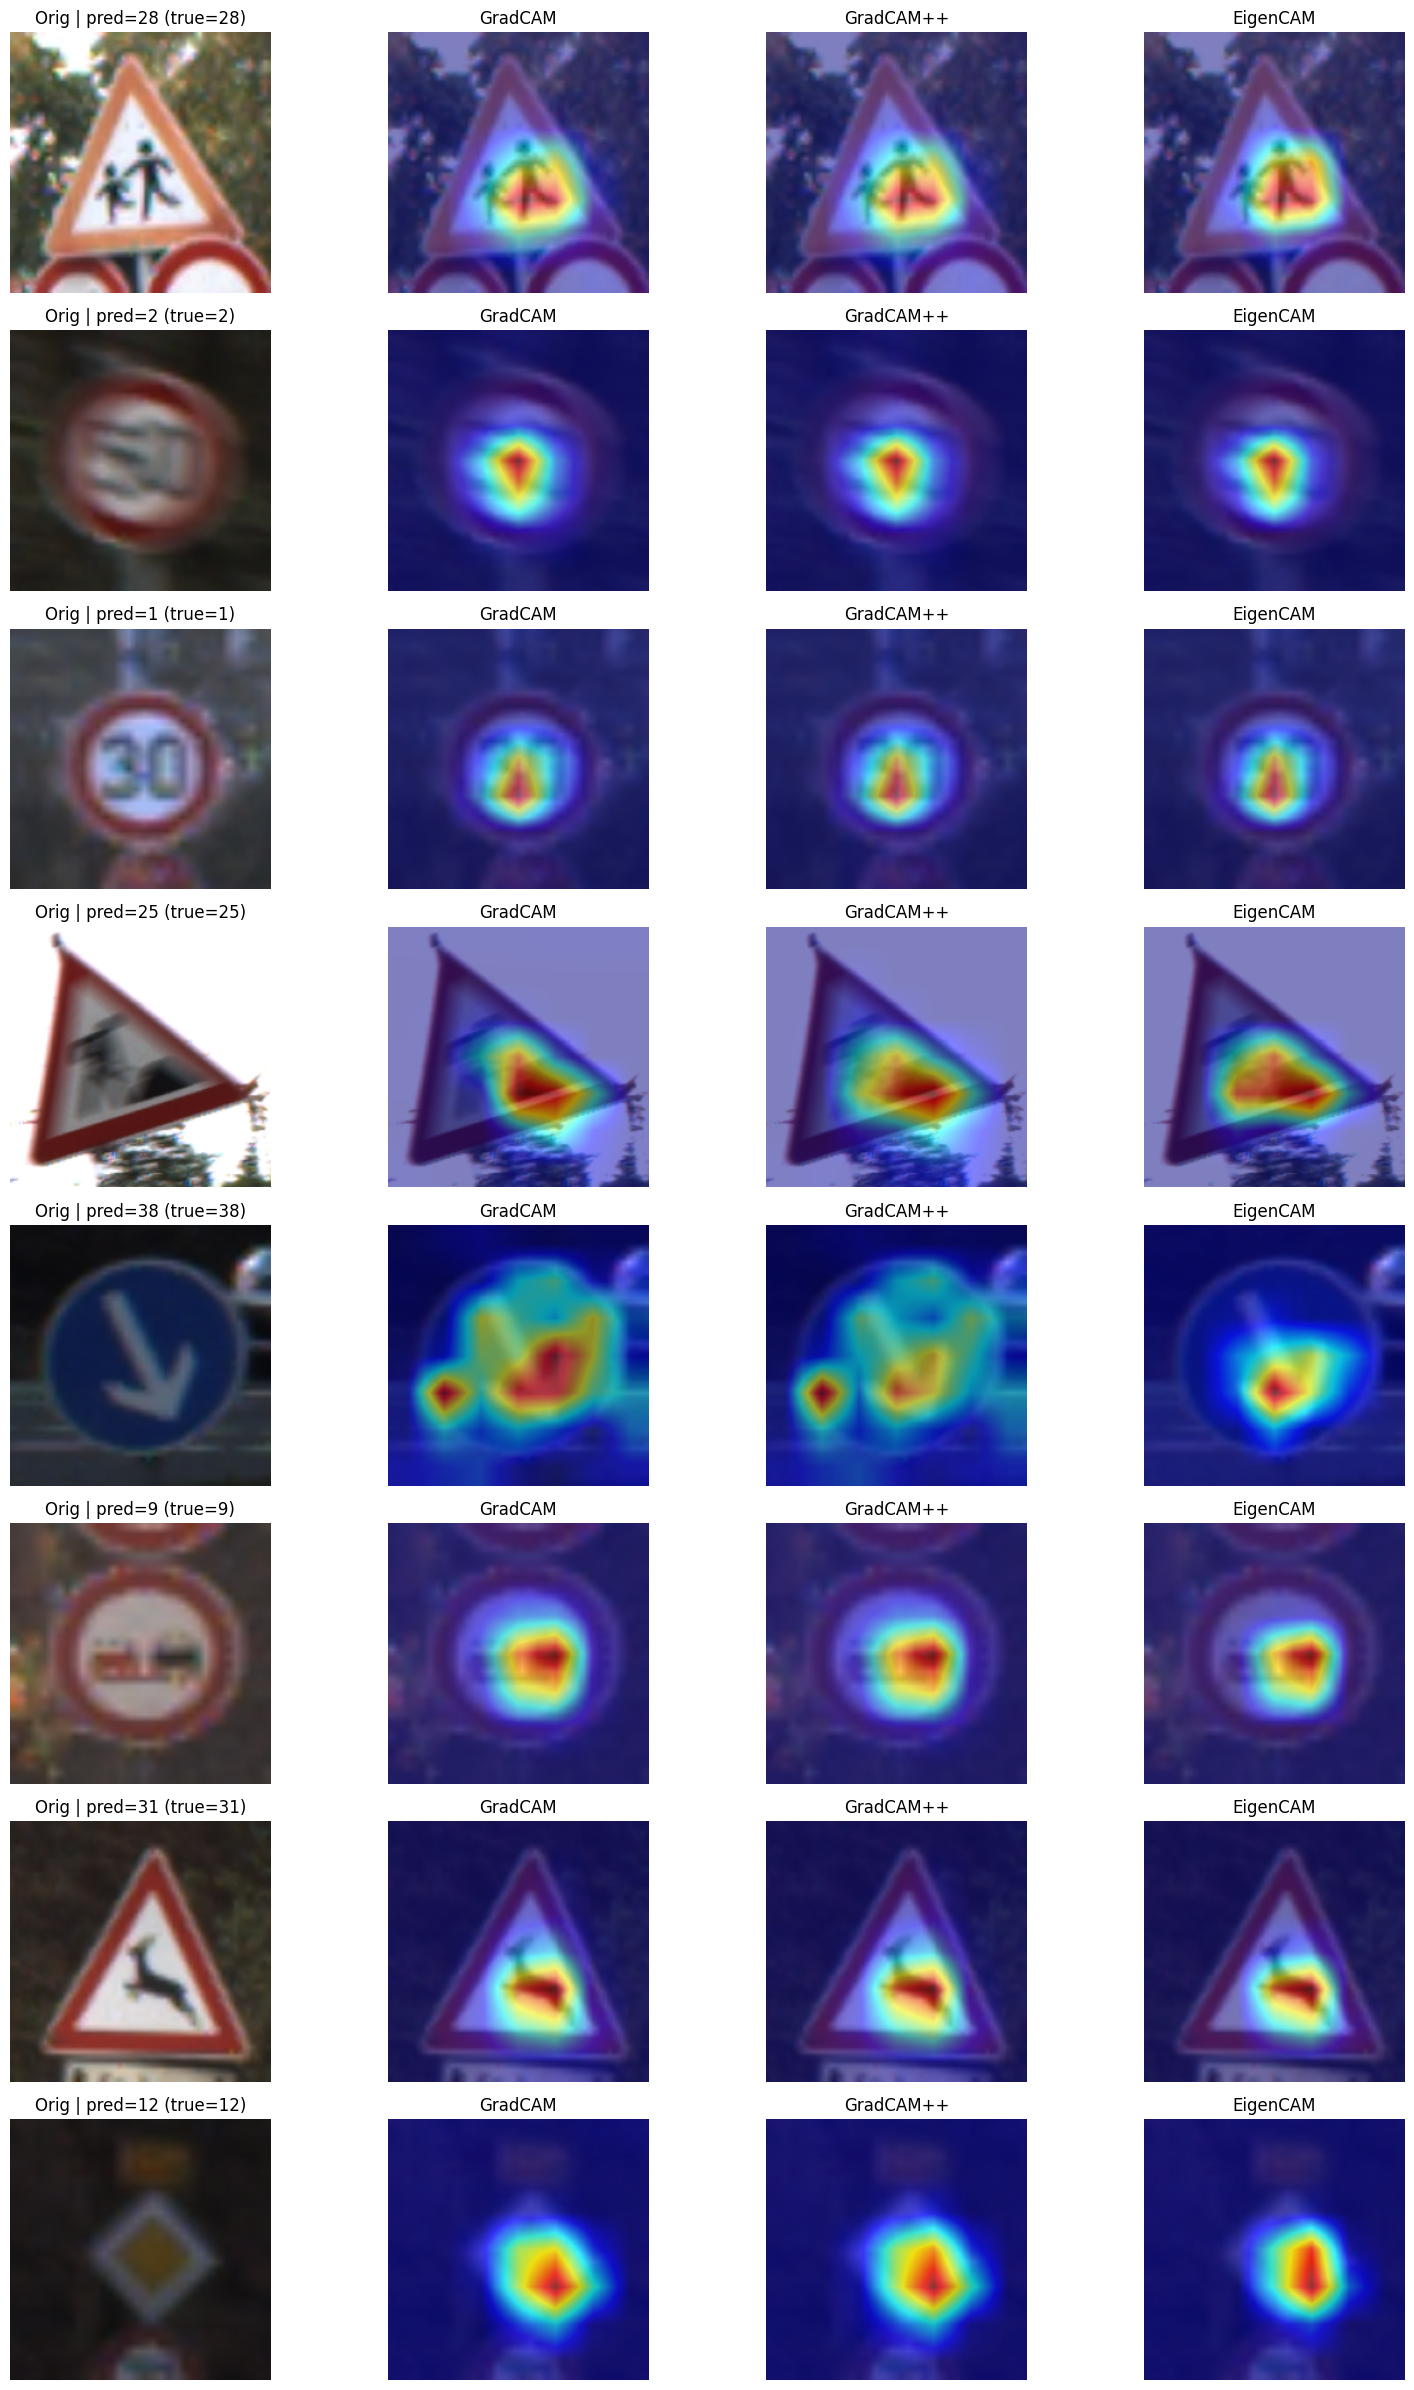

In [28]:
# Plot and save
fig, axes = plt.subplots(k, 1 + len(methods), figsize=(4*(1+len(methods)), 3*k))
if k == 1: axes = np.expand_dims(axes, 0)  # unify shape

for i in range(k):
    # original
    ax = axes[i,0]
    ax.imshow(rgb_bases[i]); ax.set_title(f"Orig | pred={int(preds[i])} (true={int(sub_labels[i])})")
    ax.axis("off")

    for j,(name, overlay, gcam) in enumerate(overlays[i], start=1):
        ax = axes[i,j]
        ax.imshow(overlay)
        ax.set_title(name)
        ax.axis("off")

plt.tight_layout()
save_path = Path("./cam_examples.png")
plt.savefig(save_path, dpi=180)
print("Saved:", save_path)

In [38]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [41]:
import json

nb_path = "/content/drive/MyDrive/Colab Notebooks/XAI_Assignment_10.2.ipynb"

with open(nb_path, "r", encoding="utf-8") as f:
    nb = json.load(f)

nb.get("metadata", {}).pop("widgets", None)

with open(nb_path, "w", encoding="utf-8") as f:
    json.dump(nb, f, ensure_ascii=False, indent=1)
